<a href="https://colab.research.google.com/github/lsh3163/MachineLearning_Study/blob/master/Keras(5)_ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5장. 컴퓨터 비전을 위한 딥러닝
## 합성곱 신경망
**_Estimated completion time: 60 minutes_**

이 장에서는 컨브넷(convnet)이라고 불리는 합성곱 신경망을 소개합니다. 차례는 아래와 같습니다.:
  1. 합성곱 신경망 소개
  2. 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기
  3. 사전 훈련된 컨브넷 사용하기
  4. 컨브넷 학습 시각화
  5. 결론

Let's go!

## 5.1 합성곱 신경망 소개

MNIST 숫자 이미지 분류에 컨브넷을 사용해보고 완전 연결 네트워크와 성능을 비교해보자.

**코드5-1:** 간단한 컨브넷 만들기 

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3),activation="relu", input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3),activation="relu"))

Using TensorFlow backend.


**NOTE:** 컨브넷이 `(image_height, image_width, image_channels)` 크기의 입력 텐서를 사용한다는 것을 알아두자.

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


다음 단계에서 마지막 층의 출력 텐서를 완전 연결 네트워크에 주입한다. 이 네트워크는 ` Dense층`을 쌓은 분류기이다. 다만 이 네트워크는 1D 벡터를 처리하므로 3D 출력을 1D텐서로 펼쳐야한다.

**코드5-2:** 컨브넷 위에 분류기 추가하기

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation="softmax"))

**NOTE:** 10개의 클래스를 분류하기 위해 마지막 층의 출력 크기를 10으로 하고 소프트맥스 활성 함수를 사용한다.

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

이제 MNIST 숫자 이미지에 이 컨브넷을 훈련해보자.

**코드5-3:** MNIST 이미지에 컨브넷 훈련하기

In [7]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000,28,28,1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000,28,28,1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer="rmsprop",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 14s 225us/step - loss: 0.1740 - acc: 0.9461
Epoch 2/5
60000/60000 [==============================] - 10s 160us/step - loss: 0.0481 - acc: 0.9853
Epoch 3/5
60000/60000 [==============================] - 10s 160us/step - loss: 0.0325 - acc: 0.9899
Epoch 4/5
60000/60000 [==============================] - 10s 160us/step - loss: 0.0247 - acc: 0.9922
Epoch 5/5
60000/60000 [==============================] - 10s 160us/step - loss: 0.0193 - acc: 0.9944


모델 평가하기

In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

10000/10000 [==============================] - 1s 99us/step
0.9893


**NOTE:** 기본적인 컨브넷은 98.9%의 테스트 정확도를 얻을 수 있었다. 좀 더 자세히 알고 싶다면 [여기](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6) 로 들어가보자.

### 5.1.1 합성곱 연산

완전 연결 층과 합성곱 층 사이의 차이는 다음과 같다. Dense 층은 입력 틍성 공간에 있는 **전역 패턴**을 학습하지만 합성곱 층은 **지역 패턴**을 학습한다. 이미지일 경우 작은 2D 윈도우 입력에서 패턴을 찾는다.

이 핵심 특징은 컨브넷에 2가지 성질을 제공한다.
  1. 학습된 패턴은 **평행 이동 불변성 **을 가진다.
  2. 컨브넷은 패턴의 **공간적 계층 구조**를 학습할 수 있다.

### 5.1.2 최대 풀링 연산

위의 예제에서 MaxPooling2D 층마다 절반으로 줄었는데 그 이유는 다음과 같다.
  1. 처리할 특성 맵의 가중치를 줄인다.
  2. 연속적인 합성곱 층이 필터의 공간적인 계층 구조를 구성한다.



## 5.2 소규모 데이터 셋에서 밑바닥부터 컨브넷 훈련하기

### 5.2.1 작은 데이터셋 문제에서 딥러닝의 타당성

이미지처럼 매우 고차원적인 문제에는 훈련 샘플이 많아야 한다. 하지만 많은 샘플이 의미하는 것은 상대적이다. 복잡한 문제를 푸는 컨브넷을 수십 개의 샘플만 사용해서 훈련하는 것은 불가능하지만 모델이 작고 규제가 잘 되어있으면 수백 개의 샘플로도 충분하다.

### 5.2.2 데이터 내려받기

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2018-10-30 00:52:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  78.5MB/s    in 0.8s    

2018-10-30 00:52:02 (78.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

**코드5-4:** 훈련, 검증, 테스트 폴더로 이미지 복사하기

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [17]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:5])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:5])

['cat.766.jpg', 'cat.601.jpg', 'cat.725.jpg', 'cat.66.jpg', 'cat.349.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` and `test`directories:

In [18]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


### 5.2.3 네트워크 구성하기

여기서 사용할 구조도 `Conv2D`와 `MaxPooling2D` 층을 번갈아 쌓은 컨브넷이다. 하지만 이미지가 더 크고 복잡한 문제이기 때문에 `Conv2D + Max` 층을 한단계 더 쌓는다.

**코드5-5:** 강아지 vs 고양이 분류를 위한 소규모 컨브넷 만들기

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

네트워크의 마지막이 시그모이드 유닛이므로 `이진 크로스엔트리`를 손실로 사용한다.

**코드5-6:** 모델의 훈련 설정하기

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

### 5.2.4 데이터 전처리

데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 한다. 단계는 아래와 같다.
  1. 사진 파일을 읽는다.
  2. JPEG를 RGB 픽셀 값으로 디코딩한다.
  3. 부동 소수 타입의 텐서로 변환한다.
  4. 픽셀 값의 스케일을 0~1로 조정한다.



**코드5-7:** ImageDataGenerator를 사용하여 디렉터리에서 이미지 읽기

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**NOTE:** 파이썬 제너레이터는 반복자처럼 작동하는 객체로 for ... in에 사용할 수 있다.

In [25]:
for data_batch, labels_batch in train_generator:
  print("배치 데이터 크기 : ", data_batch.shape)
  print("배치 레이블 크기 : ", labels_batch.shape)
  break

배치 데이터 크기 :  (20, 150, 150, 3)
배치 레이블 크기 :  (20,)


fig_generator를 모델 훈련에 사용하며 fit 메서드와 동일하되, 데이터 제너레이터를 사용할 수 있다.

**코드5-8:** 배치 제너레이터를 사용하여 모델 훈련하기

In [27]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data = validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 12s 119ms/step - loss: 0.6883 - acc: 0.5365 - val_loss: 0.6762 - val_acc: 0.5240
Epoch 2/30
100/100 [==============================] - 11s 108ms/step - loss: 0.6533 - acc: 0.6155 - val_loss: 0.6216 - val_acc: 0.6530
Epoch 3/30
100/100 [==============================] - 11s 108ms/step - loss: 0.6008 - acc: 0.6675 - val_loss: 0.5966 - val_acc: 0.6780
Epoch 4/30
100/100 [==============================] - 11s 108ms/step - loss: 0.5620 - acc: 0.7010 - val_loss: 0.5738 - val_acc: 0.7030
Epoch 5/30
100/100 [==============================] - 11s 108ms/step - loss: 0.5268 - acc: 0.7345 - val_loss: 0.6151 - val_acc: 0.6660
Epoch 6/30
100/100 [==============================] - 11s 110ms/step - loss: 0.5065 - acc: 0.7550 - val_loss: 0.5733 - val_acc: 0.7080
Epoch 7/30
100/100 [==============================] - 11s 109ms/step - loss: 0.4774 - acc: 0.7665 - val_loss: 0.5565 - val_acc: 0.7180
Epoch 8/30
100/100 [==============================] - 1

**코드5-9:** 모델 저장하기

In [0]:
model.save('cats_and_dogs_small_1.h5')

**코드5-10:** 훈련의 정확도와 손실 그래프 그리기

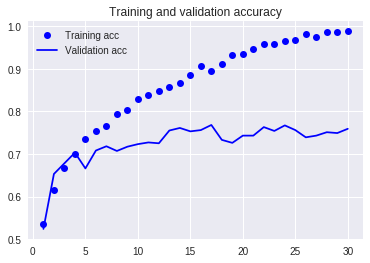

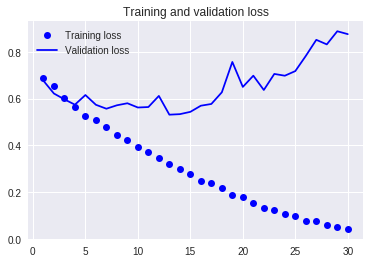

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**NOTE:** 훈련 정확도는 시간이 지남에 따라 100%에 도달하지만 검증 정확도는 70~72%에서 멈추었다.

### 5.2.5 데이터 증식 사용하기

데이터 증식은 기존 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법이다. 이 방법은 그럴듯한 이미지를 생성하도록 여러가지 랜덤한 변환을 적용하여 샘플을 늘린다.

**코드5-11:** ImageDataGenerator를 사용하여 데이터 증식 설정하기

In [0]:
datagen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True,
  fill_mode='nearest')

기능은 아래와 같다.
  * `rotation_range` : 랜덤하기 사진을 회전시킬 각도 범위(0~180)
  * `width_shift_range` : 사진을 수평과 수직으로 랜덤하기 평행이동 시킬 범위(전체 넓이와 높이에 대한 비율)
  * `shear_range` : 랜덤하게 전단 변환을 적용할 각도 범위
  * `zoom_range` : 랜덤하게 사진을 확대할 범위
  * `horizontal_flip` : 랜덤하게 이미지를 수평으로 뒤집는다.(풍경, 인물 사진)
  * `fill_mode` : 회전이나 가로/세로 이동으로 인하여 새롭게 생성해야 할 픽셀을 채울 전략

**코드5-12:** 랜덤하게 증식된 훈련 이미지 그리기

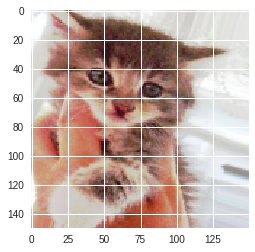

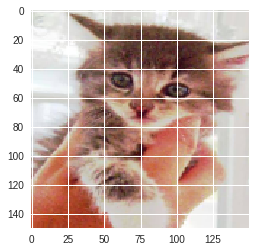

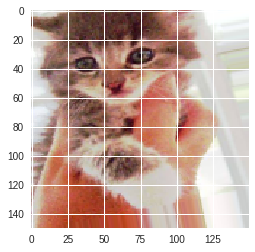

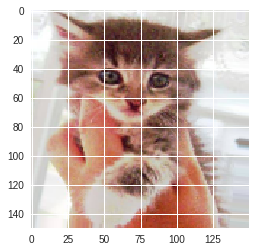

In [34]:
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for
  fname in os.listdir(train_cats_dir)])

img_path = fnames[3]

img = image.load_img(img_path, target_size=(150,150))

x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)

i=0

for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i+=1
  if i%4 ==0 :
    break
plt.show()

**코드5-13:** 드롭아웃을 포함한 새로운 컨브넷 정의하기

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

**코드5-14:** 데이터 증식 제너레이터를 사용하여 컨브넷 훈련하기

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs=100,
    validation_data = validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 37s 374ms/step - loss: 0.6918 - acc: 0.5178 - val_loss: 0.6740 - val_acc: 0.6155
Epoch 2/100
100/100 [==============================] - 34s 337ms/step - loss: 0.6770 - acc: 0.5663 - val_loss: 0.6484 - val_acc: 0.6282
Epoch 3/100
100/100 [==============================] - 34s 335ms/step - loss: 0.6686 - acc: 0.5753 - val_loss: 0.6363 - val_acc: 0.6377
Epoch 4/100
100/100 [==============================] - 33s 335ms/step - loss: 0.6474 - acc: 0.6069 - val_loss: 0.6181 - val_acc: 0.6447
Epoch 5/100
100/100 [==============================] - 33s 330ms/step - loss: 0.6305 - acc: 0.6419 - val_loss: 0.7014 - val_acc: 0.5793
Epoch 6/100
100/100 [==============================] - 36s 361ms/step - loss: 0.6157 - acc: 0.6625 - val_loss: 0.5673 - val_acc: 0.7018
Epoch 7/100
100/100 [==============================] - 33s 334ms/step - loss: 0.6060 - acc: 0.6841 -

**코드5-15:** 모델 저장하기

In [0]:
model.save('cats_dogs_small_2.h5')

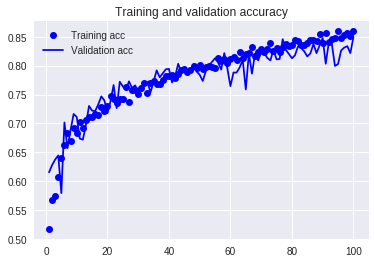

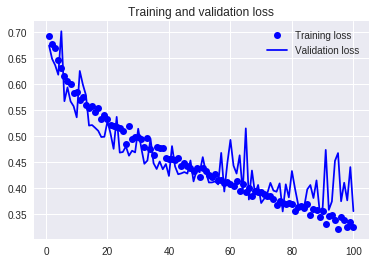

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()